In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.beta import Beta
from torch.distributions.uniform import Uniform
from torch import logsumexp
import sys
import time
import datetime
import math

In [2]:
N = 200
D = 2
## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 64
NUM_LATENTS = 1
NUM_OBS = D
BATCH_SIZE = 20
NUM_EPOCHS = 6000
LEARNING_RATE = 1e-4
CUDA = False
PATH = 'circles'

In [3]:
Xs = torch.from_numpy(np.load('crosses/obs.npy')).float()
Xs = Xs.transpose(1,0)
# mus_true = torch.from_numpy(np.load('circles/mus.npy')).float()
# rads_true = torch.from_numpy(np.load('circles/rads.npy')).float()
# num_seqs = Xs.shape[0]

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs= D,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.local_log_alpha = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        self.local_log_beta = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, N, D, num_samples):
        hidden = self.enc_hidden(obs)
        q_alpha = torch.exp(self.local_log_alpha(hidden))
        q_beta = torch.exp(self.local_log_beta(hidden))
        embed = Beta(q_alpha, q_beta).sample((num_samples,)) ## S * N
        log_q = Beta(q_alpha, q_beta).log_prob(embed)
        return q_alpha, q_beta, embed, log_q
    
    
class Decoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.dec_angles = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_obs))
        self.dec_rad = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1))

    def forward(self, embed, obs, N, D):
        angles = self.dec_angles(embed) 
        rads = self.dec_rad(embed)
        x_mus = angles * rads
        x_sigma = torch.ones((N, D)) * 0.01
        log_p_x = Normal(x_mus, x_sigma).log_prob(obs).sum(-1)
        return x_mus, log_p_x

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 1e-2)     
        
def initialize():
    enc = Encoder()
    dec = Decoder()
#     enc.apply(weights_init)
    opt1 =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99)) 
    opt2 = torch.optim.Adam(list(dec.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
    return enc, dec, opt1, opt2
enc, dec, opt1, opt2 = initialize()

In [6]:
# def reparam(q_mus, q_sigma, N, D, num_samples, batch_size):
#     eps = Normal(torch.zeros((num_samples, batch_size, N, D)), torch.ones((num_samples, batch_size, N, D))).sample()
#     ws = q_mus.unsqueeze(0).repeat(num_samples, 1, 1, 1) + torch.mul(q_sigma.unsqueeze(0).repeat(num_samples, 1, 1, 1), eps)
#     log_qs = Normal(q_mus, q_sigma).log_prob(ws).sum(-1).sum(-1) ## S * B
#     return ws, log_qs

def oneshot(x, angles, N, D, num_samples):
    log_p_xs = torch.zeros((num_samples, N))
    log_prs = torch.zeros((num_samples, N))
    log_qs = torch.zeros((num_samples, N))
    X_mus = torch.zeros((num_samples, N, D))
#     angles = embed * 2*math.pi
#     angles = embed
#     yaxis = torch.cos(angles) * 2.0
#     xaxis = torch.sin(angles) * 2.0
#     x_mus = torch.cat((xaxis, yaxis), dim=-1)
#     x_sigma = torch.ones((N, D)) * 0.01
    for s in range(num_samples):
        noise = Normal(torch.zeros(N), torch.ones(N) * 0.05).sample()
#         log_qs[s] = Normal(torch.zeros(N), torch.ones(N) * 0.05).log_prob(noise)
        angles_noisy = angles
        x_mus, log_p_x = dec(angles_noisy[:, None], x, N, D)
        X_mus[s] = x_mus
        log_p_xs[s] = log_p_x
#         log_prs[s] = Uniform(torch.zeros(N), torch.ones(N)* 2*math.pi).log_prob(angles[s].squeeze(-1)) # S * N 
#     log_p_x = Normal(x_mus, x_sigma).log_prob(x).sum(-1) ## S * N
#     log_pr = Uniform(torch.zeros(N), torch.ones(N)*2*math.pi).log_prob(embed.squeeze(-1)) # S * N 
    log_weights = log_p_xs 
#     weights = torch.exp(log_weights - logsumexp(log_weights, 0)).detach()
    elbo = log_weights.mean(0).mean()
    return elbo, X_mus


In [7]:
ELBOs = []
EUBOs = []
num_batches = int((Xs.shape[0] / BATCH_SIZE))
time_start = time.time()
angles = torch.linspace(0, math.pi*2, 40).repeat(5)
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(N)
    Xs_shuffle = Xs[indices]
    angles_shuffle = angles[indices]
    opt2.zero_grad()
    elbo, X_mus = oneshot(Xs_shuffle, angles_shuffle, N, D, NUM_SAMPLES)
    (-elbo).backward()
    opt2.step()
    
    ELBOs.append(elbo.item())
    
    if epoch%100 == 0:
        time_end = time.time()  
        print('epoch=%d, ELBO=%.3f (%ds)' % (epoch, elbo, time_end - time_start))
        time_start = time.time()


epoch=0, ELBO=-15021.430 (0s)
epoch=100, ELBO=-12867.062 (0s)
epoch=200, ELBO=-9408.864 (0s)
epoch=300, ELBO=-5684.236 (0s)
epoch=400, ELBO=-4303.874 (0s)
epoch=500, ELBO=-3692.914 (0s)
epoch=600, ELBO=-3021.942 (0s)
epoch=700, ELBO=-2307.933 (0s)
epoch=800, ELBO=-1725.508 (0s)
epoch=900, ELBO=-1333.885 (0s)
epoch=1000, ELBO=-1085.426 (0s)
epoch=1100, ELBO=-889.699 (0s)
epoch=1200, ELBO=-746.871 (0s)
epoch=1300, ELBO=-643.832 (0s)
epoch=1400, ELBO=-531.985 (0s)
epoch=1500, ELBO=-414.711 (0s)
epoch=1600, ELBO=-321.187 (0s)
epoch=1700, ELBO=-274.721 (0s)
epoch=1800, ELBO=-214.683 (0s)
epoch=1900, ELBO=-185.724 (0s)
epoch=2000, ELBO=-185.236 (0s)
epoch=2100, ELBO=-155.001 (0s)
epoch=2200, ELBO=-147.220 (0s)
epoch=2300, ELBO=-147.906 (0s)
epoch=2400, ELBO=-204.944 (0s)
epoch=2500, ELBO=-134.403 (0s)
epoch=2600, ELBO=-138.350 (0s)
epoch=2700, ELBO=-133.617 (0s)
epoch=2800, ELBO=-128.069 (0s)
epoch=2900, ELBO=-148.582 (0s)
epoch=3000, ELBO=-122.206 (0s)
epoch=3100, ELBO=-112.304 (0s)
epoch=3

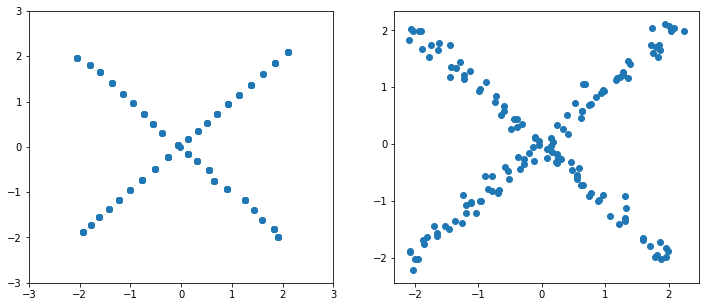

In [8]:
T = 150
for s in range(1):
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)   
    ax1.scatter(X_mus[s, :T, 0].data.numpy(), X_mus[s, :T, 1].data.numpy())
    ax2.scatter(Xs_shuffle[:T, 0].data.numpy(), Xs_shuffle[:T, 1].data.numpy())
#     ax3.plot(embed[s, :T, 0].data.numpy(), 'ro')
    ax1.set_xlim([-3,3])
    ax1.set_ylim([-3,3])


In [20]:
a = torch.linspace(0, math.pi*2, T)
x_mus, log_p_x = dec(a[:, None], Xs_shuffle[:T], T, D)

(-3, 3)

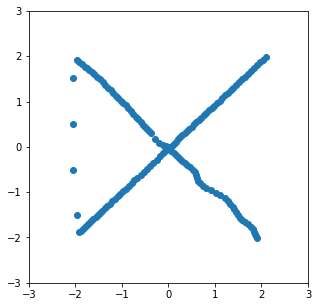

In [21]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(x_mus[:, 0].data.numpy(), x_mus[:, 1].data.numpy())
ax1.set_xlim([-3,3])
ax1.set_ylim([-3,3])

In [11]:
def save_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in):
    fout = open('results/logs-' + PATH +'.txt', 'w+')
    fout.write('EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in\n')
    for i in range(len(EUBOs)):
        fout.write(str(EUBOs[i]) + ', ' + str(ELBOs[i]) + ', ' + str(ESSs[i]) 
                   + str(KLs_eta_ex[i]) + str(KLs_eta_in[i]) + str(KLs_z_ex[i]) + str(KLs_z_in[i]) + '\n')
    fout.close()
save_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in)

NameError: name 'ESSs' is not defined

In [ ]:
def plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, num_samples):
    fig = plt.figure(figsize=(20, 30))
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')
    ax1.tick_params(labelsize=18)
    ax1.set_ylim([-220, -130])
    ax1.legend(fontsize=18)
    ##
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(KLs_eta_ex, '#66b3ff', label='KLs_eta_ex')
    ax2.plot(KLs_eta_in, '#ff9999', label='KLs_eta_in')
    ax2.plot(KLs_z_ex, '#99ff99', label='KLs_z_ex')
    ax2.plot(KLs_z_in, 'gold', label='KLs_z_in')   
    ax2.plot(np.ones(len(KLs_z_in)) * 5, 'k', label='const=5.0')
    ax2.legend(fontsize=18)
    ax2.tick_params(labelsize=18)
    ax2.set_ylim([-1, 30])
    ##
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax3.tick_params(labelsize=18)
    ax3.set_xlabel('epochs (%d gradient steps per epoch)'  % num_batches, size=18)
    ax3.legend()
    plt.savefig('results/train-' + PATH + '.svg')

In [ ]:
plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, NUM_SAMPLES)

In [ ]:
STEPS = 50
def reverse(X, z, mus_prev, precisions_prev, N, D, K, batch_size):
    data = torch.cat((X, z), dim=-1).view(batch_size*N, -1)
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions = enc_global(data, K, D, 1, batch_size)  
    log_q_eta =  Normal(q_mean[0], q_sigma[0]).log_prob(mus_prev).sum(-1).sum(-1) + Gamma(q_alpha, q_beta).log_prob(precisions_prev).sum(-1).sum(-1)## B
    return log_q_eta

def test(x, Pi, N, K, D, num_samples, steps, batch_size):
    log_increment_weights = torch.zeros((steps, num_samples, batch_size))
    log_p_joints = torch.zeros((steps, num_samples, batch_size))
    log_qf = torch.zeros((steps-1, num_samples, batch_size))
    log_qr = torch.zeros((steps-1, num_samples, batch_size))
    Z_samples = torch.zeros((num_samples, batch_size, N, K))
    mus_prevs = torch.zeros((num_samples, batch_size, K, D))
    precisions_prevs = torch.zeros((num_samples, batch_size, K, D))
    
    for m in range(steps):
        if m == 0:
            for l in range(num_samples):
                q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = Init_step(x, N, D, K, batch_size)
                mus_prevs[l] = mus
                precisions_prevs[l] = precisions
                zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                labels = z.nonzero()
                log_p_z = cat(Pi).log_prob(z).sum(-1)
                sigmas = 1. / torch.sqrt(precisions)
                log_p_x = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1)
                log_increment_weights[m, l] = log_p_x + log_p_z - log_q_z     
                log_p_joints[m, l] = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                
        else:
            for l in range(num_samples):
                z_prev = Z_samples[l]
                q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(x, z_prev, N, D, K, batch_size)
                zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
                Z_samples[l] = z
                log_p_joints[m, l] = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                log_qf[m-1, l] = log_q_eta + log_q_z
                
                mus_prev = mus_prevs[l]
                precisions_prev = precisions_prevs[l]
                
                log_qr[m-1, l] = reverse(x, z, mus_prev, precisions_prev, N, D, K, batch_size)
                log_p_joint = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
                log_increment_weights[m, l] = log_p_joint - log_q_z - log_q_eta
                mus_prevs[l] = mus
                precisions_prevs[l] = precisions
    detail_balances = log_p_joints[1:] - log_p_joints[:-1] -log_qf + log_qr
    increment_weights = torch.exp(log_increment_weights - logsumexp(log_increment_weights, 1).unsqueeze(1).repeat(1, num_samples, 1)).detach()
    esses = (1./ (increment_weights ** 2).sum(1))                   
    log_last_weights = log_increment_weights[-1] ## S * B
    ## EUBO and ELBO
    eubos = torch.mul(increment_weights, log_increment_weights).sum(1).mean(-1)
    elbos = log_increment_weights.mean(1).mean(-1)     
    return eubos, elbos, esses, log_increment_weights, detail_balances

In [ ]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    batch_Xs = Xs[batch_indices]
    batch_Xs = shuffler(batch_Xs, N, K, D, batch_size)
    return batch_Xs
batch_Xs = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)
eubo, elbo, ess, log_increment_weights, detail_balances = test(batch_Xs, Pi, N, K, D, NUM_SAMPLES, STEPS, BATCH_SIZE)

In [ ]:

detail_balances.shape

In [ ]:
for i in range(BATCH_SIZE):
    log_weights = log_increment_weights[:, :, i]
    ess_stepwise = ess[:, i].data.numpy()
    fig = plt.figure(figsize=(20,6))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    weights = torch.exp(log_weights - logsumexp(log_weights, -1)[:, None]).data.numpy()
    db = detail_balances[:, :, i].mean(-1)
    ax1.plot(db.data.numpy(), 'r-o')
    ax1.set_ylim([-20, 20])
    for s in range(NUM_SAMPLES):
        ax2.plot(ess_stepwise, 'b-o')
        ax3.plot(weights[:, s], 'g-o')
        ax2.set_ylim([1.0, 7])


In [ ]:
ess

In [ ]:


def test(x, num_seqs, Pi, N, K, D, steps, batch_size):
    LLs = [] 
    for m in range(steps):
        if m == 0:
            mus, precisions, log_p_eta = inti_global(K, D, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
            zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
        else:
            q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(x, z, N, D, K, batch_size)
            zs_pi, z, log_q_z = E_step(x, mus, precisions, N, D, K, batch_size)
            labels = z.nonzero()
            sigmas = 1. / torch.sqrt(precisions)
            ll = Normal(mus[labels[:, 0], labels[:, -1], :].view(batch_size, N, D), sigmas[labels[:, 0], labels[:, -1], :].view(batch_size, N, D)).log_prob(x).sum(-1).sum(-1).mean()
            LLs.append(ll.item())
    E_precisions = q_alpha / q_beta
    E_mus = q_mean
    E_z = torch.argmax(zs_pi, dim=-1)

    return z, mus, precisions, LLs, E_mus, E_precisions, E_z

x,z_true = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)
z, mus, precisions, LLs, E_mus, E_precisions, E_z = test(x, num_seqs, Pi, N, K, D, STEPS, BATCH_SIZE)

In [ ]:
def plot_final_samples(Xs, Zs, mus, precisions, steps, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,100))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
        z = Zs[b].data.numpy()
        mu = mus[b].data.numpy()
        precision = precisions[b].data.numpy()

        covs = np.zeros((K, D, D))
        assignments = z
        for k in range(K):
            covs[k] = np.diag(1. / precision[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=covs[k], pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('results/modes' + PATH + '.svg')

In [ ]:
plot_final_samples(x, E_z, E_mus, E_precisions, STEPS, BATCH_SIZE)

In [ ]:
plt.plot(LLs[:20])

In [ ]:
plt.plot(LLs)

In [ ]:
plt.plot(LLs[:10])

In [ ]:
np.array(LLs).mean()

In [ ]:
np.exp(-3)